<img typeof="foaf:Image" src="ANTI-INFECTIVES-RGB_200pc.png" alt="Wellcome Centre for Anti-Infectives Research" title="">

# Visualisation of Protein Abundance in T. brucei: TREU927

Michele Tinti and Michael A.J. Ferguson

Wellcome Centre for Anti-Infectives Research
School of Life Sciences, University of Dundee



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#set up code
import sys
#sys.path.append('../ProLib')
import utilities as PTUT
import warnings
warnings.filterwarnings("ignore")
#define helphttp://localhost:8888/notebooks/calvin/new_data/analysis_427_2018.ipynb#ing function
import os
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from adjustText import adjust_text
from matplotlib.lines import Line2D
from Bio import SeqIO
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
plt.style.use('ggplot')

# Load Data

In [3]:
OUT_FOLDER = '927/'
!mkdir -p '927/'

In [4]:
df = pd.read_csv('927/proteinGroups_ibaq.txt.gz',sep='\t')
df = PTUT.clean_df(df, score=-1, unique_pep_threshold=-1)

starting from: (7075, 1507)
removed  222 Protein Groups by: Only identified by site
tot  222  entries removed
---------------
removed  67 Protein Groups by: Reverse
tot  289  entries removed
---------------
removed  143 Protein Groups by: Potential contaminant
tot  432  entries removed
---------------
Score
nothing removed
---------------
Peptide counts (razor+unique)
nothing removed
---------------


In [5]:
#list(df.columns)

In [6]:
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int
163,gene-Tb427.BES40.1,gene-Tb427.BES40.1,12,12,12,gene-Tb427.BES40.1 lcl|FM162566.1_prot_CAQ5727...,1,12,12,12,...,163,3020;29323;42773;43014;51958;68122;76679;82146...,True;True;True;True;True;True;True;True;True;T...,3324;32339;47073;47352;57107;75564;85952;91692...,102897;102898;102899;102900;102901;102902;1029...,165259;165260;165261;165262;165263;165264;1652...,165281;1363160;1984376;1991954;2438470;3159155...,188;189,1;26,12
164,gene-Tb427.BES40.10;Tb11.57.0050.1-p1;Tb11.114...,gene-Tb427.BES40.10,21;3;3;2;2;2;2;2;2;2;2;2;2;1;1;1;1,9;0;1;0;0;0;1;0;0;0;0;0;0;1;0;1;0,4;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,gene-Tb427.BES40.10 lcl|FM162566.1_prot_CAQ572...,17,21,9,4,...,164,16215;20764;23323;29656;37679;38919;38920;4239...,True;False;True;False;True;False;False;False;F...,17860;22874;25655;25656;32689;41526;41527;4288...,488182;488183;488184;488185;488186;488187;4881...,791739;791740;791741;791742;791743;791744;7917...,791748;992098;1103432;1381081;1755688;1811935;...,190;191;192;193;194;195,78;130;155;157;171;272,9
165,gene-Tb427.BES40.13,gene-Tb427.BES40.13,26,5,5,gene-Tb427.BES40.13 lcl|FM162566.1_prot_CAQ572...,1,26,5,5,...,165,116;1821;2098;16505;17506;25684;30750;31406;40...,False;False;False;False;False;False;False;Fals...,133;2015;2319;18239;19320;28356;33862;34593;44...,5432;5433;5434;5435;5436;5437;5438;5439;66180;...,9446;9447;9448;9449;9450;9451;9452;9453;108937...,9448;108964;124043;806094;847770;1199020;14344...,196;197,953;1101,5
166,gene-Tb427.BES40.14,gene-Tb427.BES40.14,30,3,3,gene-Tb427.BES40.14 lcl|FM162566.1_prot_CAQ572...,1,30,3,3,...,166,11404;15484;15844;22545;23527;23535;23795;2552...,False;False;False;False;False;False;False;Fals...,12642;17031;17420;24810;24811;25882;25890;2616...,363031;363032;363033;363034;363035;363036;4672...,594168;594169;594170;594171;594172;594173;7587...,594172;758739;773702;1067305;1113497;1113620;1...,198;199;200,9;68;85,3
167,gene-Tb427.BES40.15,gene-Tb427.BES40.15,31,1,0,gene-Tb427.BES40.15 lcl|FM162566.1_prot_CAQ572...,1,31,1,0,...,167,11404;11833;15484;15844;22545;23527;23535;2379...,False;False;False;False;False;False;False;Fals...,12642;13090;17031;17420;24810;24811;25882;2589...,363031;363032;363033;363034;363035;363036;3692...,594168;594169;594170;594171;594172;594173;6042...,594172;604222;758739;773702;1067305;1113497;11...,198;199;200,9;68;85,1


In [7]:
df[df['Protein IDs'].str.contains('gene-Tb427.BES40.16')]
#gene-Tb427.BES40.16

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int
168,gene-Tb427.BES40.16;Tb09.v4.0154:pseudogenic_t...,gene-Tb427.BES40.16,21;4,21;4,5;0,gene-Tb427.BES40.16 lcl|FM162566.1_prot_CAQ572...,2,21,21,5,...,168,16217;20764;23324;29656;31682;31683;38919;3892...,True;True;True;True;True;True;True;True;True;T...,17862;17863;22874;25657;25658;32689;34890;3489...,488232;488233;488234;488235;488236;488237;4882...,791813;791814;791815;791816;791817;791818;7918...,791849;992098;1103551;1381081;1474041;1474079;...,192;193;194;195;201,78;130;155;157;171,21


In [8]:
bsf_cols = [n for n in  list(df.columns) if 'iBAQ H BSF' in n]
bsf = df[bsf_cols]
bsf.columns = [n.split(' ')[-1] for n in bsf.columns]
bsf_cols = bsf.columns
pcf_cols = [n for n in  list(df.columns) if 'iBAQ H PCF' in n]
pcf = df[pcf_cols]
pcf.columns = [n.split(' ')[-1] for n in pcf.columns]
pcf_cols = pcf.columns
bsf = bsf.replace(0,np.nan)
pcf = pcf.replace(0,np.nan)
bsf.head()
merge = pd.concat([bsf,pcf],axis=1)
merge.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18573000.0,20727000.0,11592000.0,15733000.0,13488000.0,8017600.0,23501000.0,3685100.0,7971900.0,33116000.0
164,11530000.0,16113000.0,15700000.0,12597000.0,11177000.0,16781000.0,14136000.0,17894000.0,14760000.0,14883000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,7710.2,17054.0,7753.4,21114.0,3657.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,4941.2,81635.0,57929.0,NaN,20322.0,29168.0,14464.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,75872.0,113910.0,118140.0,82414.0,75623.0,97324.0,101580.0,85075.0,75567.0,82928.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Missing Values

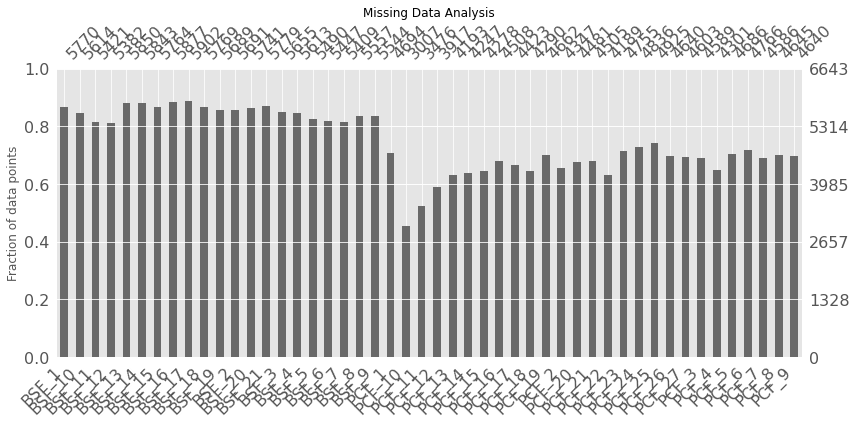

In [9]:
import missingno as msno
#visualization of missing data
ax=msno.bar(merge,figsize=(12, 6))
plt.title('Missing Data Analysis', size=12)
ax.set_ylabel('Fraction of data points',size=12)
plt.savefig(os.path.join(OUT_FOLDER,'1_missing_value.png'))
plt.tight_layout()
plt.show()

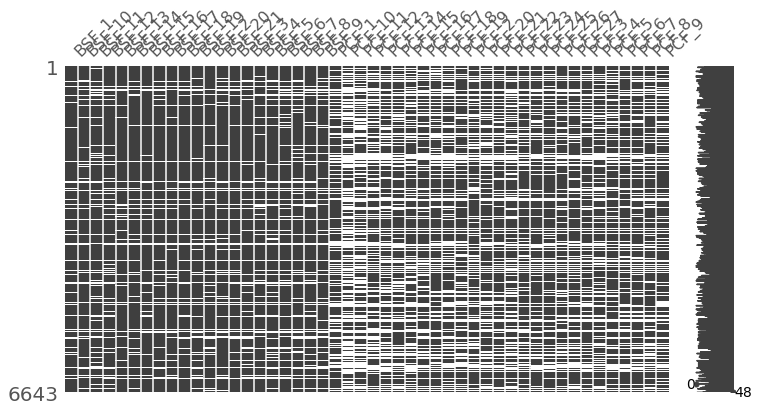

In [10]:
#print(data.shape)
msno.matrix(merge, figsize=(12, 6))
#plt.title('Missing Data')
plt.savefig(os.path.join(OUT_FOLDER,'missing_value_matrix.png'))
plt.show()

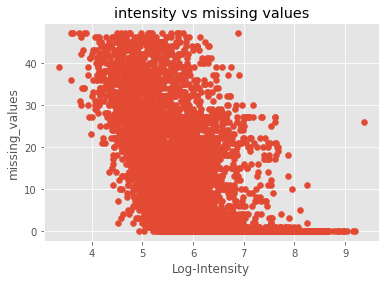

In [11]:
mean_intesity = np.log10(merge.mean(axis=1))
na_sum = merge.isna().sum(axis=1).astype(int)
plt.scatter(mean_intesity,na_sum)
plt.xlabel('Log-Intensity')
plt.ylabel('missing_values')
plt.title('intensity vs missing values')
plt.show()

# Normalisation

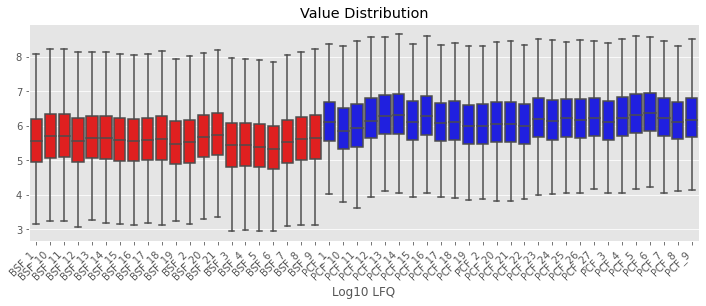

In [12]:
palette=['r']*len(bsf_cols)+['b']*len(pcf_cols)
palette_g = ['r','b']
color_dictionary = {'r':'BSF','b':'PCF'}


fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=np.log10(merge),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

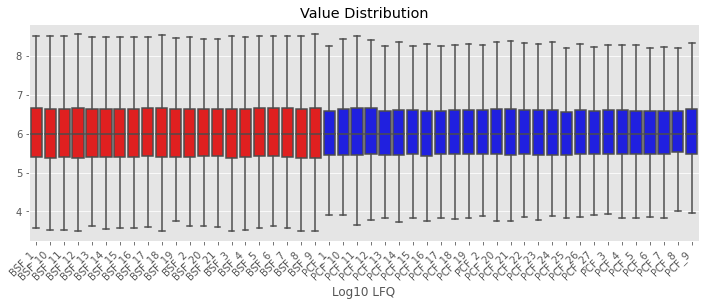

In [13]:
#https://codereview.stackexchange.com/questions/25417/is-there-a-better-way-to-make-a-function-silent-on-need
class NoStdStreams(object):
    def __init__(self, stdout = None, stderr = None):
        self.devnull = open(os.devnull,'w')
        self._stdout = stdout or self.devnull or sys.stdout
        self._stderr = stderr or self.devnull or sys.stderr

    def __enter__(self):
        self.old_stdout, self.old_stderr = sys.stdout, sys.stderr
        self.old_stdout.flush(); self.old_stderr.flush()
        sys.stdout, sys.stderr = self._stdout, self._stderr

    def __exit__(self, exc_type, exc_value, traceback):
        self._stdout.flush(); self._stderr.flush()
        sys.stdout = self.old_stdout
        sys.stderr = self.old_stderr
        self.devnull.close()

with NoStdStreams():
    merge_normed = PTUT.norm_loading(merge)

fig,ax=plt.subplots(figsize=(12,4))
sns.boxplot(data=np.log10(merge_normed),showfliers=False,palette=palette,ax=ax)
plt.title('Value Distribution')
plt.xlabel('Log10 LFQ')
plt.xticks(rotation=45,ha='right')
plt.savefig(os.path.join(OUT_FOLDER,'4_value_distribution_box.png'))
plt.show()

In [14]:
#merge_normed['bsf_median']=merge_normed[bsf_cols].median(axis=1,skipna=True)
#merge_normed['pcf_median']=merge_normed[pcf_cols].median(axis=1,skipna=True)
#merge_normed.head()

In [15]:
merge_normed=merge_normed.replace(0,np.nan)

In [16]:
log_merge_normed = np.log10(merge_normed)
log_merge_normed.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.034222,7.129269,6.818942,7.076467,6.900299,6.577278,6.999386,6.34199,6.782959,7.330628
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,4.241221,4.643235,4.327455,4.731550,3.931773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,4.133278,5.210002,5.053691,NaN,4.653502,4.819062,4.571697,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
merge_normed_BSF = merge_normed[[n for n in merge_normed.columns if n.startswith('BSF_')]]
merge_normed_PCF = merge_normed[[n for n in merge_normed.columns if n.startswith('PCF_')]]
#log_merge_normed_BSF_m1=log_merge_normed_BSF-1
#log_merge_normed_PCF_m1=log_merge_normed_PCF-1

count    6643.00000
mean        3.11546
std         6.05819
min         0.00000
25%         0.00000
50%         0.00000
75%         2.00000
max        21.00000
dtype: float64


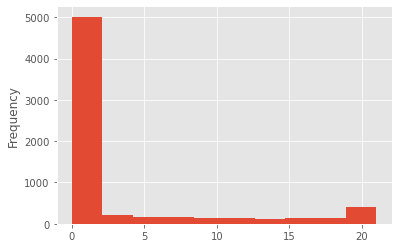

In [18]:
na_bsf = merge_normed_BSF.isna().sum(axis=1)
na_bsf.plot(kind='hist')
print(na_bsf.describe())
#log_merge_normed_BSF[na_bsf>10]=np.nan

count    6643.000000
mean        9.057956
std         9.760090
min         0.000000
25%         0.000000
50%         5.000000
75%        18.000000
max        27.000000
dtype: float64


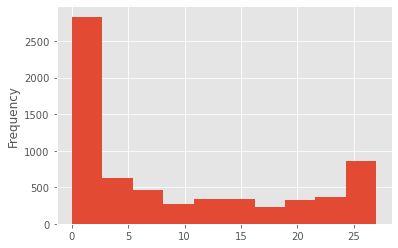

In [19]:
na_pcf = merge_normed_PCF.isna().sum(axis=1)
na_pcf.plot(kind='hist')
print(na_pcf.describe())
#log_merge_normed_PCF[na_pcf>19]=np.nan

# Input Missing Values

In [20]:
def get_random(in_col, strategy):
    if strategy == 'small':
        mean_random = in_col[in_col>0].min()
        std_random = mean_random*0.05
        random_values = np.random.normal(mean_random, 
                                         scale=std_random, 
                                         size=in_col.shape[0])
    if strategy == 'median':
        pass
        
    return  random_values

#add a small random value to each element
#of a cloumn, optionally plots the distribution
#of the random values
def impute(in_col, ax=False, strategy='small'):
    random_values = get_random(in_col, strategy=strategy)
    if ax:
        np.log10(pd.Series(random_values)).plot(kind='hist',histtype='step', 
                          density=True,ax=ax,label=in_col.name)  
    
    fake_col = in_col.copy()
    fake_col = fake_col+random_values
    index = in_col[in_col==0].index.values 
    in_col.loc[index] = fake_col.loc[index] 
    return in_col  

In [21]:
log_merge_normed.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,PCF_25,PCF_26,PCF_27,PCF_3,PCF_4,PCF_5,PCF_6,PCF_7,PCF_8,PCF_9
163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.034222,7.129269,6.818942,7.076467,6.900299,6.577278,6.999386,6.34199,6.782959,7.330628
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,4.241221,4.643235,4.327455,4.731550,3.931773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,4.133278,5.210002,5.053691,NaN,4.653502,4.819062,4.571697,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
for n in log_merge_normed.columns:
    log_merge_normed[n] = impute(log_merge_normed[n].fillna(0))

In [23]:
imputed_X = log_merge_normed.copy()

In [24]:
#imputed_X.loc[[172]].plot(kind='bar')

In [25]:
#fig,ax=plt.subplots(figsize=(8,8))
#imputed_X.plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax)
#imputed_X.loc[[172]].plot(kind='scatter',x='log_pcf_median',y='log_bsf_median',ax=ax,c='r')

In [26]:
imputed_X['bsf_median']=imputed_X[bsf_cols].median(axis=1)
imputed_X['pcf_median']=imputed_X[pcf_cols].median(axis=1)

In [27]:
imputed_X['rank_bsf_median']=imputed_X['bsf_median'].rank(method='min')
imputed_X['rank_pcf_median']=imputed_X['pcf_median'].rank(method='min')

<AxesSubplot:xlabel='bsf_median', ylabel='pcf_median'>

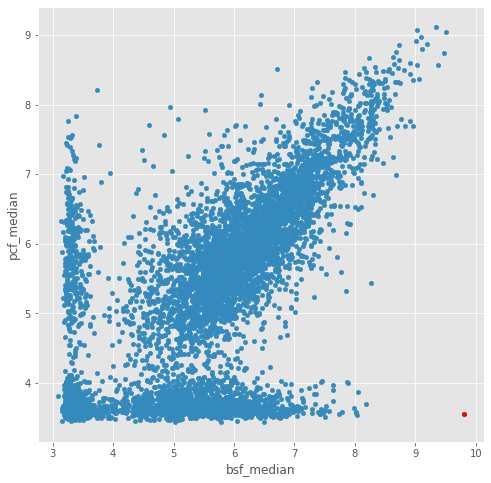

In [28]:
fig,ax=plt.subplots(figsize=(8,8))
imputed_X.plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax)
imputed_X.loc[[172]].plot(kind='scatter',x='bsf_median',y='pcf_median',ax=ax,c='r')

<AxesSubplot:xlabel='rank_bsf_median', ylabel='rank_pcf_median'>

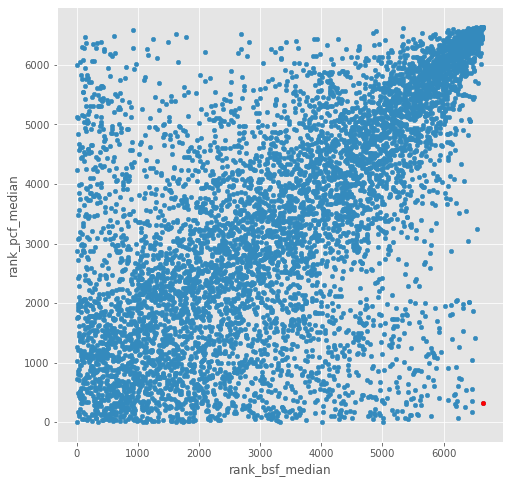

In [29]:
fig,ax=plt.subplots(figsize=(8,8))
imputed_X.plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax)
imputed_X.loc[[172]].plot(kind='scatter',x='rank_bsf_median',y='rank_pcf_median',ax=ax,c='r')

In [30]:
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int
163,gene-Tb427.BES40.1,gene-Tb427.BES40.1,12,12,12,gene-Tb427.BES40.1 lcl|FM162566.1_prot_CAQ5727...,1,12,12,12,...,163,3020;29323;42773;43014;51958;68122;76679;82146...,True;True;True;True;True;True;True;True;True;T...,3324;32339;47073;47352;57107;75564;85952;91692...,102897;102898;102899;102900;102901;102902;1029...,165259;165260;165261;165262;165263;165264;1652...,165281;1363160;1984376;1991954;2438470;3159155...,188;189,1;26,12
164,gene-Tb427.BES40.10;Tb11.57.0050.1-p1;Tb11.114...,gene-Tb427.BES40.10,21;3;3;2;2;2;2;2;2;2;2;2;2;1;1;1;1,9;0;1;0;0;0;1;0;0;0;0;0;0;1;0;1;0,4;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0;0,gene-Tb427.BES40.10 lcl|FM162566.1_prot_CAQ572...,17,21,9,4,...,164,16215;20764;23323;29656;37679;38919;38920;4239...,True;False;True;False;True;False;False;False;F...,17860;22874;25655;25656;32689;41526;41527;4288...,488182;488183;488184;488185;488186;488187;4881...,791739;791740;791741;791742;791743;791744;7917...,791748;992098;1103432;1381081;1755688;1811935;...,190;191;192;193;194;195,78;130;155;157;171;272,9
165,gene-Tb427.BES40.13,gene-Tb427.BES40.13,26,5,5,gene-Tb427.BES40.13 lcl|FM162566.1_prot_CAQ572...,1,26,5,5,...,165,116;1821;2098;16505;17506;25684;30750;31406;40...,False;False;False;False;False;False;False;Fals...,133;2015;2319;18239;19320;28356;33862;34593;44...,5432;5433;5434;5435;5436;5437;5438;5439;66180;...,9446;9447;9448;9449;9450;9451;9452;9453;108937...,9448;108964;124043;806094;847770;1199020;14344...,196;197,953;1101,5
166,gene-Tb427.BES40.14,gene-Tb427.BES40.14,30,3,3,gene-Tb427.BES40.14 lcl|FM162566.1_prot_CAQ572...,1,30,3,3,...,166,11404;15484;15844;22545;23527;23535;23795;2552...,False;False;False;False;False;False;False;Fals...,12642;17031;17420;24810;24811;25882;25890;2616...,363031;363032;363033;363034;363035;363036;4672...,594168;594169;594170;594171;594172;594173;7587...,594172;758739;773702;1067305;1113497;1113620;1...,198;199;200,9;68;85,3
167,gene-Tb427.BES40.15,gene-Tb427.BES40.15,31,1,0,gene-Tb427.BES40.15 lcl|FM162566.1_prot_CAQ572...,1,31,1,0,...,167,11404;11833;15484;15844;22545;23527;23535;2379...,False;False;False;False;False;False;False;Fals...,12642;13090;17031;17420;24810;24811;25882;2589...,363031;363032;363033;363034;363035;363036;3692...,594168;594169;594170;594171;594172;594173;6042...,594172;604222;758739;773702;1067305;1113497;11...,198;199;200,9;68;85,1


In [31]:
temp = PTUT.mod_df(imputed_X.join(df,how='left'))
temp['Gene_acc']=np.arange(temp.shape[0])
temp.rename({'desc':'Desc'},axis=1,inplace=True)
temp.head()

,BSF_1,BSF_10,BSF_11,BSF_12,BSF_13,BSF_14,BSF_15,BSF_16,BSF_17,BSF_18,...,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,unique_int,Gene_id,Desc,Gene_acc
163,3.102013,3.271415,3.788066,3.356965,3.297662,3.255182,3.349340,3.207908,3.068068,3.675605,...,3324;32339;47073;47352;57107;75564;85952;91692...,102897;102898;102899;102900;102901;102902;1029...,165259;165260;165261;165262;165263;165264;1652...,165281;1363160;1984376;1991954;2438470;3159155...,188;189,1;26,12,gene-Tb427.BES40.1,BES40.1,0
164,7.501275,7.505302,7.486695,7.520282,7.393861,7.578973,7.561735,7.690670,7.576066,7.541315,...,17860;22874;25655;25656;32689;41526;41527;4288...,488182;488183;488184;488185;488186;488187;4881...,791739;791740;791741;791742;791743;791744;7917...,791748;992098;1103432;1381081;1755688;1811935;...,190;191;192;193;194;195,78;130;155;157;171;272,9,gene-Tb427.BES40.10,BES40.10,1
165,3.314849,3.064560,3.428874,3.088309,3.148590,4.241221,4.643235,4.327455,4.731550,3.931773,...,133;2015;2319;18239;19320;28356;33862;34593;44...,5432;5433;5434;5435;5436;5437;5438;5439;66180;...,9446;9447;9448;9449;9450;9451;9452;9453;108937...,9448;108964;124043;806094;847770;1199020;14344...,196;197,953;1101,5,gene-Tb427.BES40.13,BES40.13,2
166,4.133278,5.210002,5.053691,3.115375,4.653502,4.819062,4.571697,3.170471,2.895149,3.585942,...,12642;17031;17420;24810;24811;25882;25890;2616...,363031;363032;363033;363034;363035;363036;4672...,594168;594169;594170;594171;594172;594173;7587...,594172;758739;773702;1067305;1113497;1113620;1...,198;199;200,9;68;85,3,gene-Tb427.BES40.14,BES40.14,3
167,5.319528,5.354688,5.363192,5.336016,5.224190,5.342375,5.418217,5.367765,5.285312,5.287325,...,12642;13090;17031;17420;24810;24811;25882;2589...,363031;363032;363033;363034;363035;363036;3692...,594168;594169;594170;594171;594172;594173;6042...,594172;604222;758739;773702;1067305;1113497;11...,198;199;200,9;68;85,1,gene-Tb427.BES40.15,BES40.15,4


# Save Data for Web App

In [32]:
!mkdir -p 'web_data/E927'

In [33]:

temp[['Gene_acc','Gene_id','bsf_median',
      'pcf_median','rank_bsf_median','rank_pcf_median','Desc',
      'Protein IDs']].to_csv('web_data/E927/indata.csv',index=False)

In [34]:
pcf_cols

Index(['PCF_1', 'PCF_10', 'PCF_11', 'PCF_12', 'PCF_13', 'PCF_14', 'PCF_15',
       'PCF_16', 'PCF_17', 'PCF_18', 'PCF_19', 'PCF_2', 'PCF_20', 'PCF_21',
       'PCF_22', 'PCF_23', 'PCF_24', 'PCF_25', 'PCF_26', 'PCF_27', 'PCF_3',
       'PCF_4', 'PCF_5', 'PCF_6', 'PCF_7', 'PCF_8', 'PCF_9'],
      dtype='object')

In [35]:
temp2 = merge_normed.fillna(0)
temp2 = PTUT.mod_df(temp2.join(df,how='left'))

temp2['Gene_acc']=np.arange(temp2.shape[0])
temp2.rename({'desc':'Desc'},axis=1,inplace=True)
#temp2[list(bsf_cols)+list(pcf_cols)]=np.log10(temp2[list(bsf_cols)+list(pcf_cols)])

temp2[['Gene_acc','Gene_id']+
      list(bsf_cols)+list(pcf_cols)+['Desc','Protein IDs']].to_csv('web_data/E927/indata2.csv',index=False)

